# - Ingestion and Cleaning

In this notebook, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that we'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Defining the directories that contain the files downloaded
dir_cs = '2003_download'
# path to the directory where all the *.csv.zip files are located

# Defining the output path for the pickle
pickle_file = "2003_download\\" + "clean_data.pickle" 
# path to save cleaned data

In [4]:
# Identifying the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt','funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
                'annual_inc', 'verification_status','issue_d', 'loan_status', 'purpose', 'dti',
                'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
                'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries','last_pymnt_d']


# Identifying the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt','annual_inc',  'dti', 'open_acc','revol_bal' ,  'total_pymnt', 'recoveries' ,'delinq_2yrs','pub_rec', 'fico_range_high', 'fico_range_low']
cat_cols = [ 'term', 'grade', 'emp_length','home_ownership' , 'verification_status', 'loan_status', 'purpose'] 
# categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensuring that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [11]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    
    if directory[-1] != "/":
        directory+= "/"
        
    
    all_files =  os.listdir(directory)
    # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        #i = i.replace(".zip", "")
        print("    Reading file " + i)
        
        output[i] = pd.read_csv(directory+i,dtype='str', skiprows =1, compression='zip' )
        # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(lambda x:is_integer(x))
        # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
#             print(invalid_rows)
            output[i] = output[i][invalid_rows]
            #remove invalid rows
    
    return output # return dictionary of dataframe

In [12]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory 2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 42535 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 188181 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 235629 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 421095 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 133887 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 97854 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 99120 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 103546 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 96779 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 105451 invalid rows which were removed
    Reading file LoanStat

### Combine the files

In [13]:
files_cs.keys()

dict_keys(['LoanStats3a_securev1.csv.zip', 'LoanStats3b_securev1.csv.zip', 'LoanStats3c_securev1.csv.zip', 'LoanStats3d_securev1.csv.zip', 'LoanStats_securev1_2016Q1.csv.zip', 'LoanStats_securev1_2016Q2.csv.zip', 'LoanStats_securev1_2016Q3.csv.zip', 'LoanStats_securev1_2016Q4.csv.zip', 'LoanStats_securev1_2017Q1.csv.zip', 'LoanStats_securev1_2017Q2.csv.zip', 'LoanStats_securev1_2017Q3.csv.zip', 'LoanStats_securev1_2017Q4.csv.zip', 'LoanStats_securev1_2018Q1.csv.zip', 'LoanStats_securev1_2018Q2.csv.zip', 'LoanStats_securev1_2018Q3.csv.zip', 'LoanStats_securev1_2018Q4.csv.zip', 'LoanStats_securev1_2019Q1.csv.zip', 'LoanStats_securev1_2019Q2.csv.zip', 'LoanStats_securev1_2019Q3.csv.zip', 'LoanStats_securev1_2019Q4.csv.zip'])

In [14]:
# combine "files_cs" into a pandas dataframe
data_cs = pd.concat(files_cs.values())
data_cs.reset_index(drop = True,)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777771,158872331,NaN,3000,3000,3000,36 months,17.74%,108.07,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777772,158833440,NaN,10000,10000,10000,36 months,6.46%,306.31,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777773,158748525,NaN,19000,19000,19000,36 months,6.46%,581.99,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777774,158298751,NaN,10000,10000,10000,60 months,28.80%,316.21,D,D5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## Preparing Final Dataset

In [15]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [16]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecasting the columns

In [17]:

for i in float_cols:
    final_data[i] = final_data[i].astype("float") # typecast float columns

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\607679399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype("float") # typecast float columns


In [18]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(lambda x : clean_perc(x))# apply clean_perc to percentage columns

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\4107308680.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(lambda x : clean_perc(x))# apply clean_perc to percentage columns


In [19]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(lambda x : clean_date(x)) 
    # typecast date cloumns to datatime using clean_date

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\2587472064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(lambda x : clean_date(x))


In [20]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x : None if pd.isnull(x) else x)
# for categorical features if the value is null/empty set it to None

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\2310750127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(lambda x : None if pd.isnull(x) else x)


## Calculate returns for each loan

In [21]:
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [22]:
# Removing all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length']!=0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\2563325437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')


Removed 12361 rows


In [23]:
final_data.reset_index(drop=True,inplace=True)

### M1-Pessimistic Method

In [24]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = (final_data["total_pymnt"] -final_data["funded_amnt"])/ final_data["funded_amnt"] +\
                            12/final_data['term_num']

C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\2930165079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months
C:\Users\bhara\AppData\Local\Temp\ipykernel_31848\2930165079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['ret_PESS'] = (final_data["total_pymnt"] -final_data["funded_amnt"])/ final_data["funded_amnt"] +\


### M2-Optimistic Method

In [25]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = (final_data["total_pymnt"] -final_data["funded_amnt"])/ final_data["funded_amnt"] +\
                            12/final_data['loan_length']
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data['ret_PESS']

### Method 3

In [26]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculating the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length

    # Assuming the amount is immediately re-invested at the prime
    # rate, finding the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1 - np.power(1 + i, final_data.loan_length)) / (1 - (1 + i)) ) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (np.power(1 + i, remaining_months)))-  final_data.funded_amnt 

    # Finding the percentage return
    ret_val = (12/T) * (final_return/final_data.funded_amnt)
    return ret_val

In [27]:
final_data['ret_INTa'] = ret_method_3(60,0.023) # calling ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60,0.04) # calling ret_method_3 with T=60, i=0.04

### Visualize the variables

In [28]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = list(final_data[i].nlargest(3)) # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [29]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print("Column name:",i) # print field name
        print("Number of distinct values:",final_data[i].nunique()) # print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [30]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


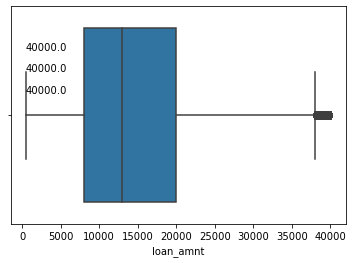

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


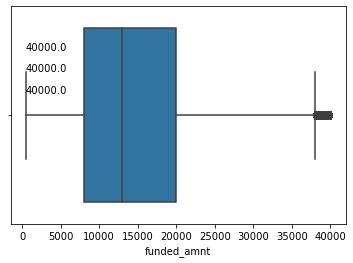

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


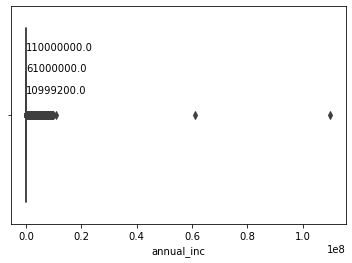

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


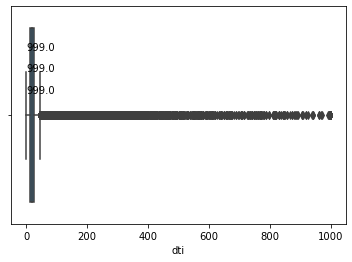

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


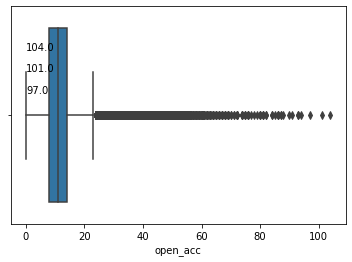

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


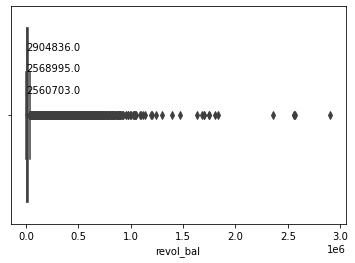

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


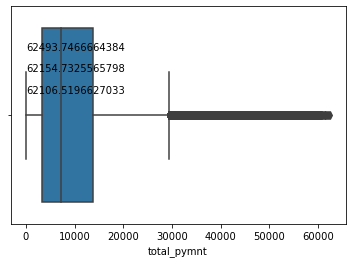

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


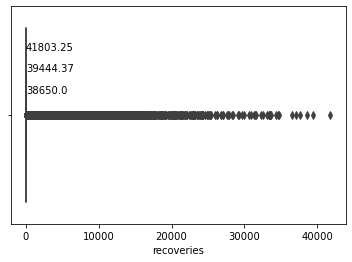

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


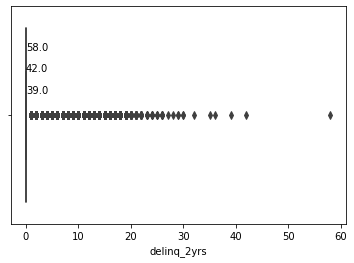

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


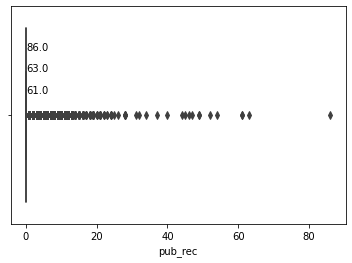

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


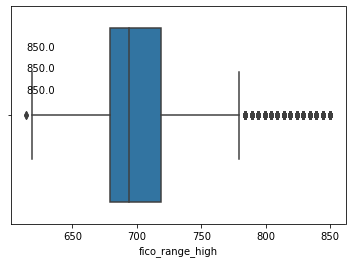

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


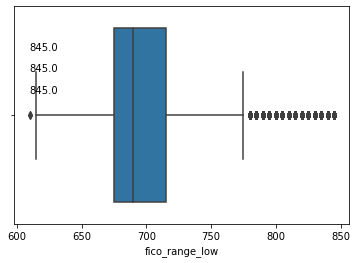

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


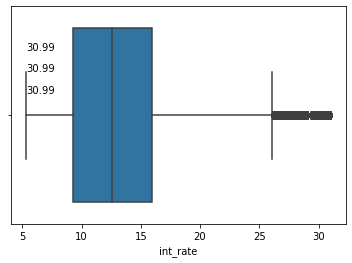

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


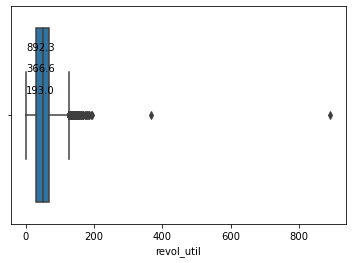

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


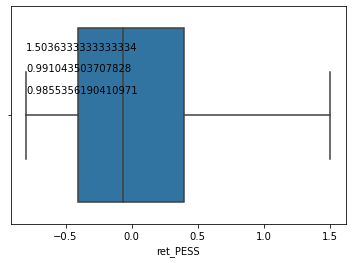

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


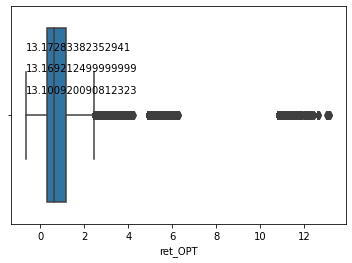

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


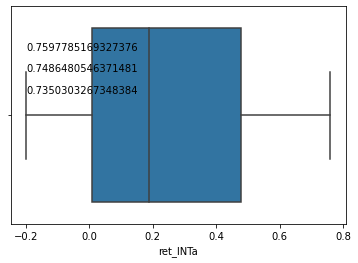

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


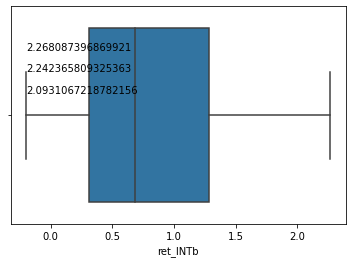

Column name: term
Number of distinct values: 2
 36 months    1949756
 60 months     815659
Name: term, dtype: int64


Column name: grade
Number of distinct values: 7
B    811304
C    768632
A    596277
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


Column name: emp_length
Number of distinct values: 11
10+ years    898370
< 1 year     253650
2 years      247379
3 years      219762
1 year       183001
5 years      171829
4 years      166566
6 years      123700
7 years      110120
8 years      107507
9 years       91449
Name: emp_length, dtype: int64


Column name: home_ownership
Number of distinct values: 6
MORTGAGE    1359007
RENT        1090600
OWN          312178
ANY            3393
OTHER           182
NONE             55
Name: home_ownership, dtype: int64


Column name: verification_status
Number of distinct values: 3
Source Verified    1066701
Not Verified        997623
Verified            701091
Name: verification_status, dtype: int64


Column name: loa

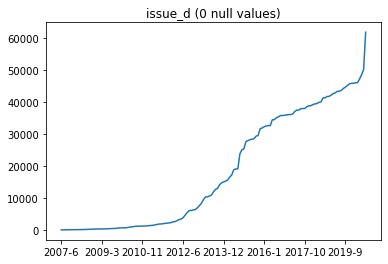

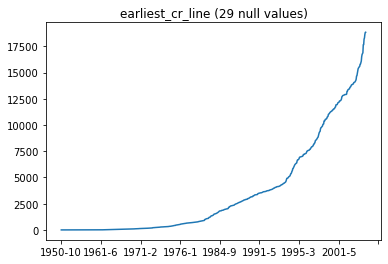

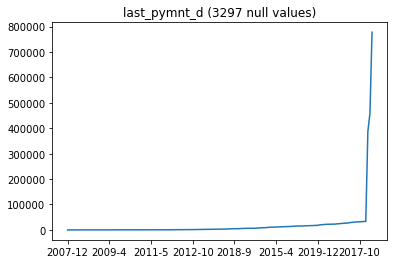

In [31]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

In [32]:
final_data['dti']

0          27.65
1           1.00
2           8.72
3          20.00
4          17.94
           ...  
2765410    30.01
2765411    14.18
2765412     6.00
2765413     2.10
2765414     8.76
Name: dti, Length: 2765415, dtype: float64

### Handle outliers

In [33]:
n_rows = len(final_data)

final_data = final_data[final_data['annual_inc']<10000000] # remove outliers based 1st obvious feature
final_data = final_data[final_data['revol_bal']<2000000]
final_data = final_data[final_data['revol_util']<250]
final_data = final_data[final_data['delinq_2yrs']<31]
final_data = final_data[final_data['pub_rec']<60]



print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 2479 rows


In [34]:
# Removing all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status']!='Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1558250 rows


In [35]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d']>=datetime.date(2010,1,1)]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 8217 rows


### Drop null values

In [36]:
# Dealing with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data.dropna(subset=list(required_cols),inplace=True) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3963 rows


### Visualize clean data

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


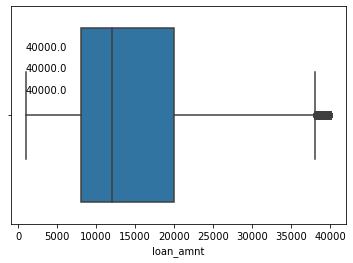

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


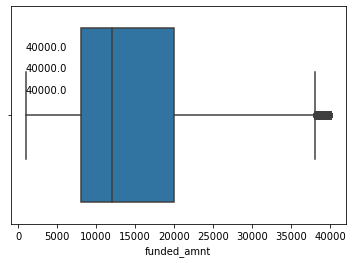

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


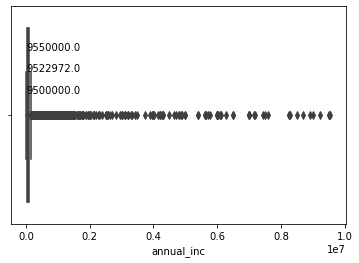

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


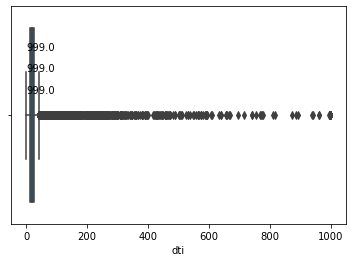

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


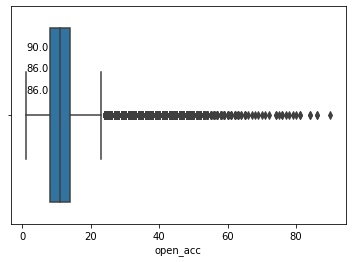

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


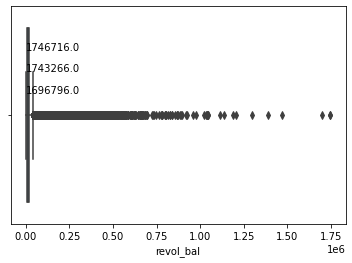

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


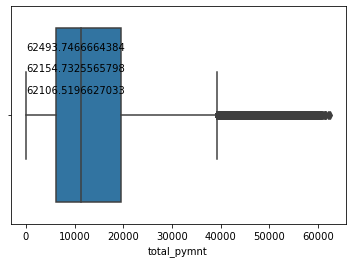

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


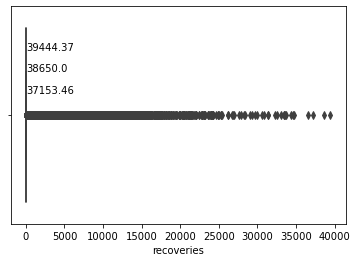

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


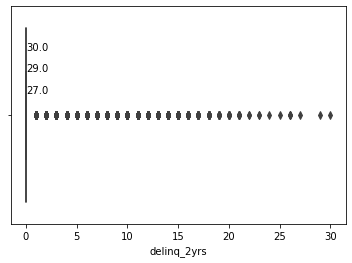

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


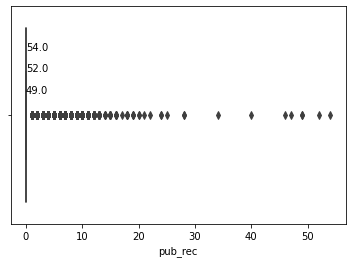

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


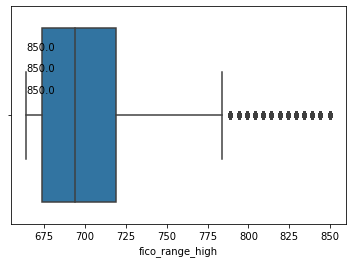

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


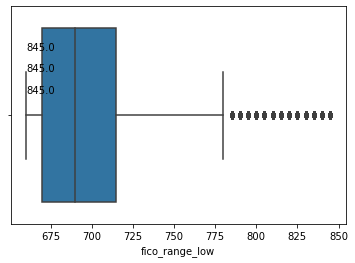

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


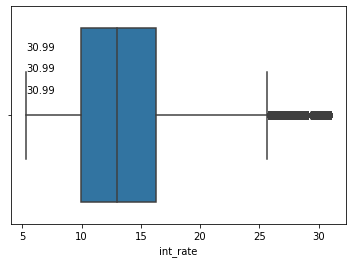

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


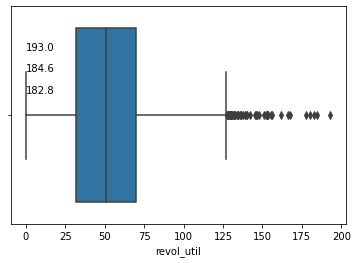

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


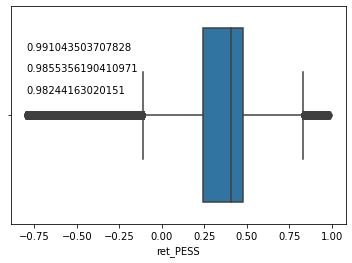

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


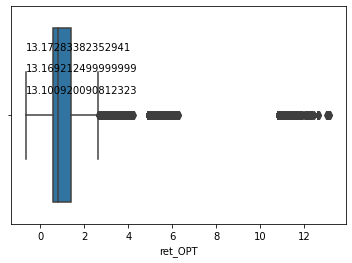

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


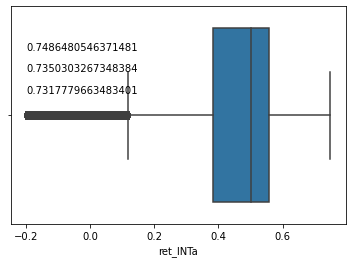

C:\Users\bhara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


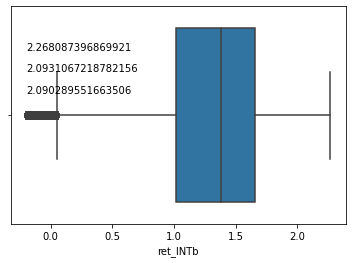

Column name: term
Number of distinct values: 2
 36 months    891199
 60 months    301307
Name: term, dtype: int64


Column name: grade
Number of distinct values: 7
B    336662
C    332342
A    211754
D    191040
E     84575
F     28397
G      7736
Name: grade, dtype: int64


Column name: emp_length
Number of distinct values: 11
10+ years    387212
2 years      107807
< 1 year      97403
3 years       95656
1 year        78618
5 years       75610
4 years       72118
6 years       56778
7 years       53380
8 years       52711
9 years       42956
Name: emp_length, dtype: int64


Column name: home_ownership
Number of distinct values: 6
MORTGAGE    592790
RENT        471298
OWN         127588
ANY            736
OTHER           50
NONE            44
Name: home_ownership, dtype: int64


Column name: verification_status
Number of distinct values: 3
Source Verified    448168
Not Verified       383056
Verified           361282
Name: verification_status, dtype: int64


Column name: loan_status
Nu

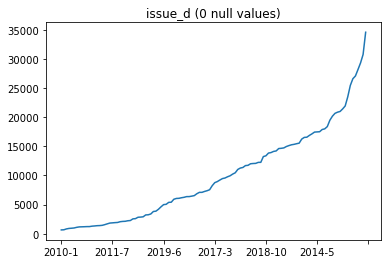

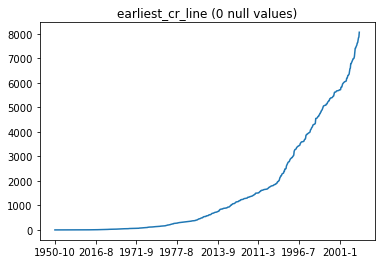

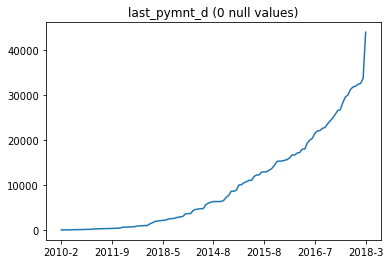

In [37]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

<AxesSubplot:>

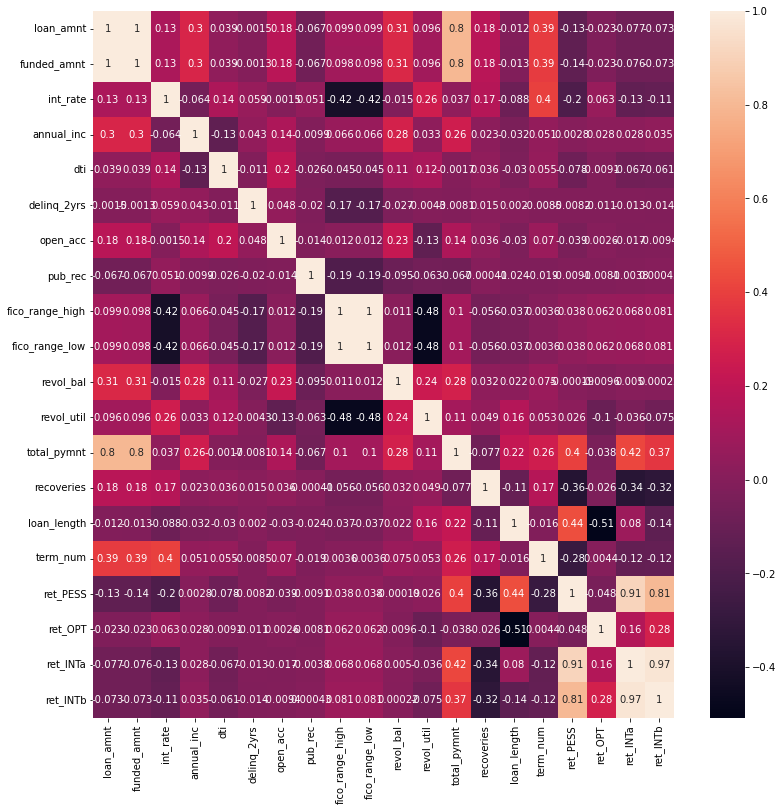

In [38]:
# Visualize the feature correlations
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 13))
corr=final_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True,ax=ax)

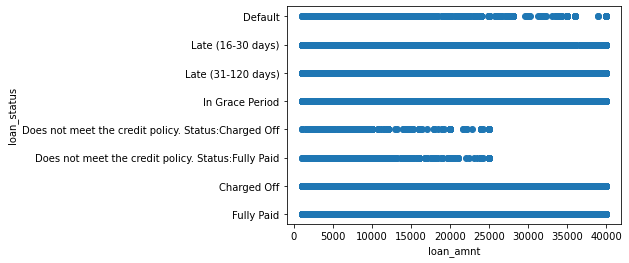

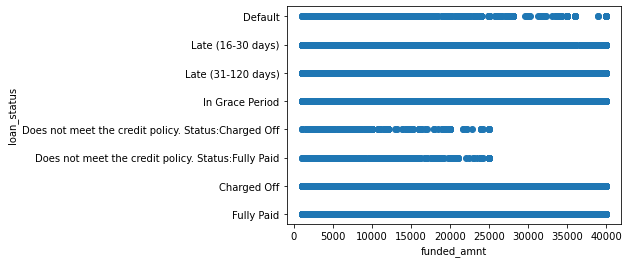

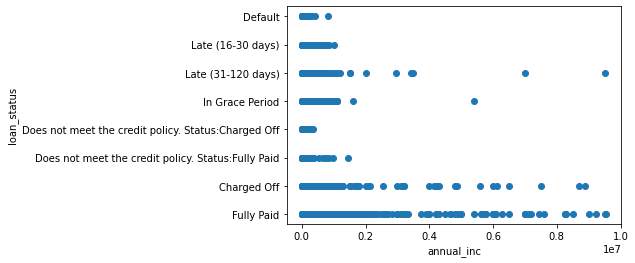

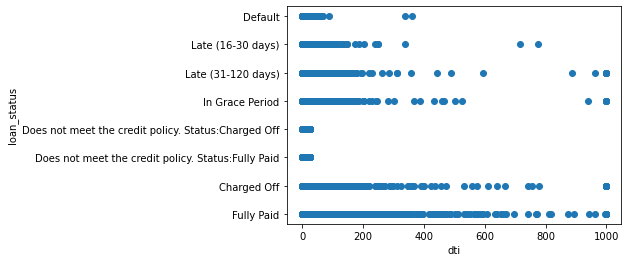

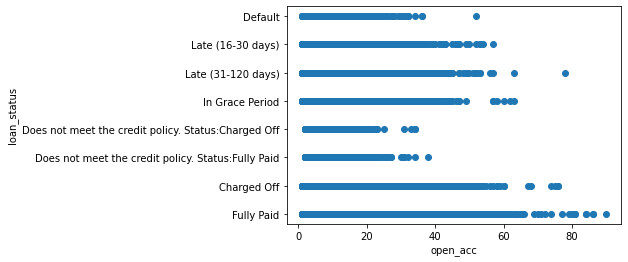

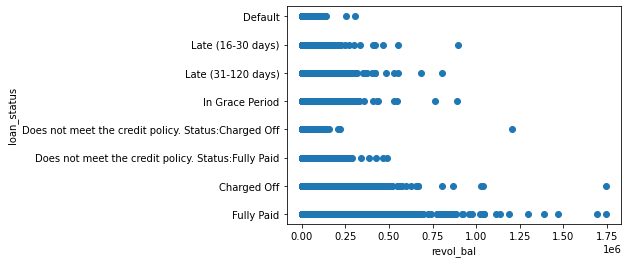

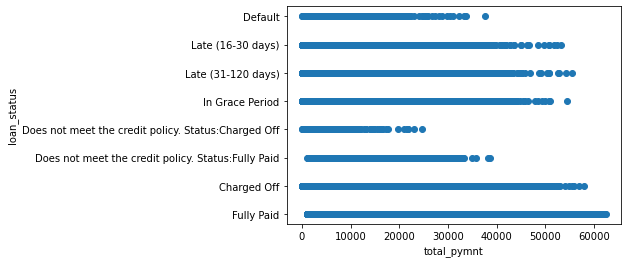

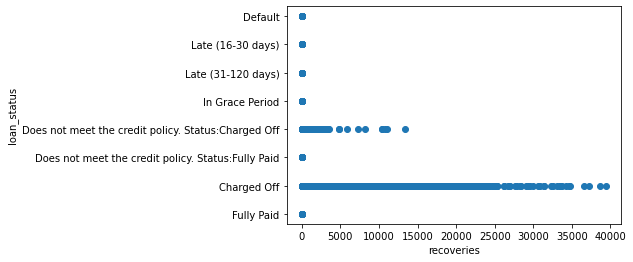

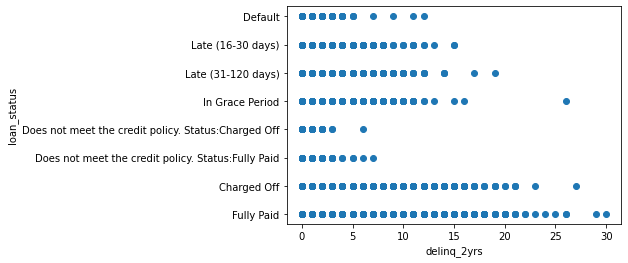

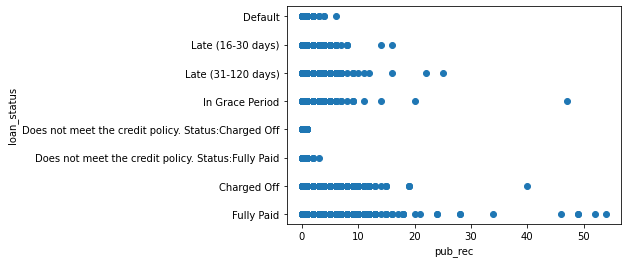

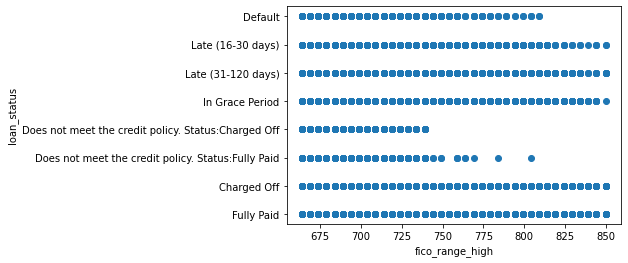

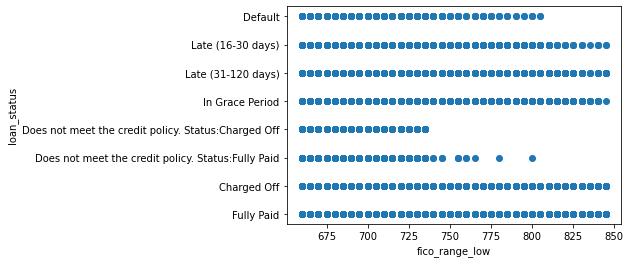

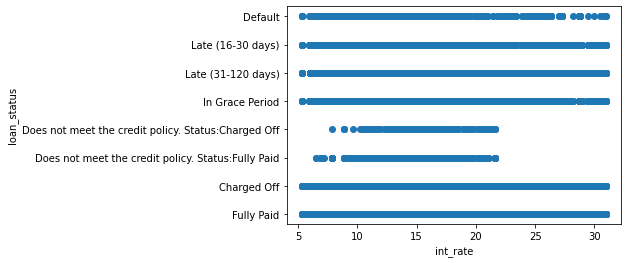

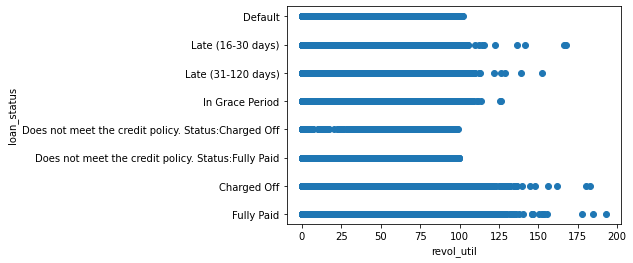

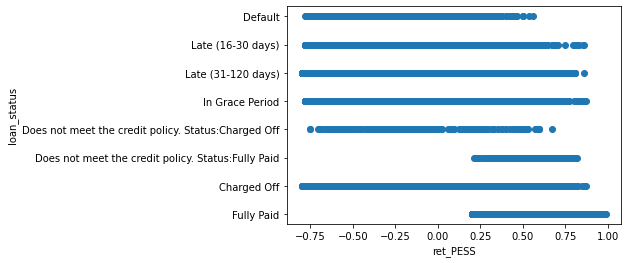

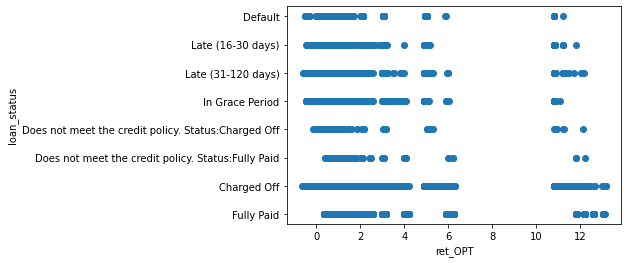

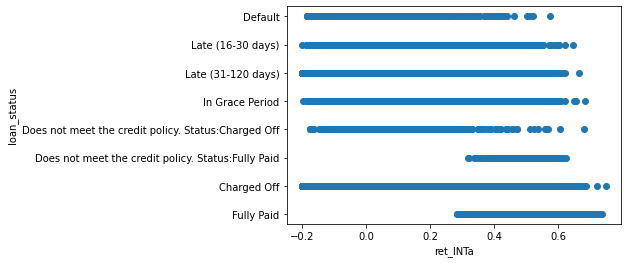

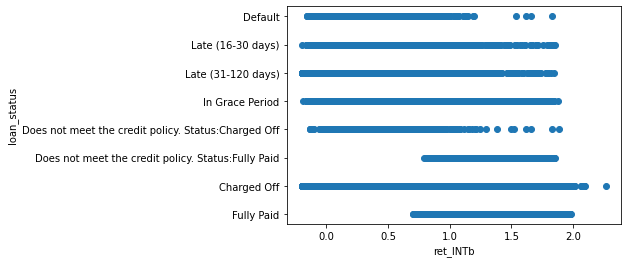

In [39]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
for col in float_cols + perc_cols + ret_cols:
    plt.scatter(x=final_data[col],y=final_data['loan_status'])
    plt.xlabel(col)
    plt.ylabel('loan_status')
    plt.show()

### Data Exploration

In [40]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade').agg({'ret_OPT':'mean'}) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade').agg({'ret_PESS':'mean'}) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade').agg({'ret_INTa':'mean'}) # average return for M3
ret_by_grade_INTb = final_data.groupby('grade').agg({'ret_INTb':'mean'}) # average return for M3
int_rate_by_grade = final_data.groupby('grade').agg({'int_rate':'mean'}) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,17.757060,9.208327,7.221118,1.394685,0.347594,0.445251,1.316969
B,28.231472,17.785197,10.882361,1.369832,0.321003,0.432577,1.280858
C,27.869210,28.227549,14.231611,1.473430,0.258236,0.409517,1.233966
D,16.020045,36.647822,18.109706,1.582821,0.211456,0.388937,1.187303
E,7.092208,43.506946,21.351506,1.521320,0.169627,0.376713,1.152735
F,2.381288,49.308025,24.882461,1.569195,0.130559,0.363299,1.118552
G,0.648718,53.955533,27.473188,1.858501,0.063813,0.337867,1.075296


In [41]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = list(set(float_cols)-set(['total_pymnt','recoveries']))

In [42]:
# saving the pickle file for the modelling phase
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )

In [43]:
final_data['recoveries']

0            0.0
1          122.9
2            0.0
3            0.0
4            0.0
           ...  
2765234      0.0
2765279      0.0
2765288      0.0
2765292      0.0
2765410      0.0
Name: recoveries, Length: 1192506, dtype: float64